In [12]:
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [13]:
conn = pymysql.connect(host='localhost',port=int(3307), user='root', password='docker',db='foodmart')

query_sales="""
select * from sales_fact_1998
"""
df_sales=pd.read_sql(query_sales, con=conn)

/tmp/ipykernel_894535/3930765474.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales=pd.read_sql(query_sales, con=conn)


In [14]:
df_sales=df_sales[df_sales['promotion_id'] == 0]
df_sales.head()

,product_id,time_id,customer_id,promotion_id,store_id,store_sales,store_cost,unit_sales
174,466,752,9953,0,1,7.89,2.9193,3.0
175,1335,752,9953,0,1,9.64,4.3380,4.0
176,699,752,9953,0,1,4.26,1.4910,3.0
177,637,752,9953,0,1,2.58,0.7740,3.0
178,94,752,9953,0,1,1.86,0.8742,3.0


In [15]:
df_sales['recency']=df_sales['time_id'].max()-df_sales['time_id']+1
df_sales=df_sales[['product_id','customer_id','store_sales','recency','time_id']]
df_sales.head()

,product_id,customer_id,store_sales,recency,time_id
174,466,9953,7.89,314,752
175,1335,9953,9.64,314,752
176,699,9953,4.26,314,752
177,637,9953,2.58,314,752
178,94,9953,1.86,314,752


In [16]:
sales=df_sales.groupby('customer_id').agg(
    frequency=('time_id', 'nunique'),
    monetary=('store_sales','sum'),
    recency=('recency', 'min')
)
sales.head()

,frequency,monetary,recency
customer_id,,,
3,2,104.63,228
6,1,40.46,159
8,6,131.41,4
9,1,40.17,218
10,2,59.68,171


In [17]:
sales['f_score']=pd.cut(sales['frequency'], 5, labels=[1, 2, 3, 4, 5])
sales['r_score']=pd.cut(sales['recency'], 5, labels=[5, 4, 3, 2, 1])
sales['m_score']=pd.cut(sales['monetary'], 5, labels=[1, 2, 3, 4, 5])
sales['customer_value']=sales['f_score'].astype(int) * 3 + sales['m_score'].astype(int) * 2 + sales['r_score'].astype(int) * 5
sales.head()

,frequency,monetary,recency,f_score,r_score,m_score,customer_value
customer_id,,,,,,,
3,2,104.63,228,1,2,1,15
6,1,40.46,159,1,3,1,20
8,6,131.41,4,1,5,1,30
9,1,40.17,218,1,2,1,15
10,2,59.68,171,1,3,1,20


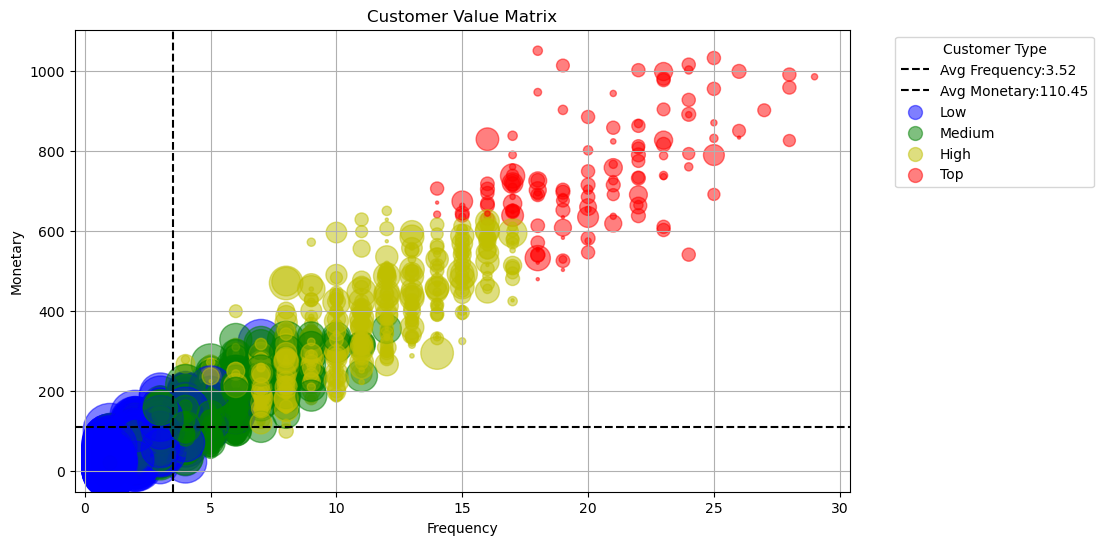

In [18]:
sales['type'] = pd.cut(sales['customer_value'], 4, labels=['Low','Medium','High','Top'])

colors_map = {'Low':'b', 'Medium':'g','High':'y','Top':'r'}
colors = sales['type'].map(colors_map)

plt.figure(figsize=(10,6))
bubble_size = sales['recency'] * 5
plt.scatter(sales['frequency'], sales['monetary'], s=bubble_size, alpha=0.5, c=colors)

avg_f = sales['frequency'].mean()
avg_m = sales['monetary'].mean()

plt.axvline(avg_f, color='black', linestyle='--', linewidth=1.5, label=f'Avg Frequency:{avg_f:.2f}')
plt.axhline(avg_m, color='black', linestyle='--', linewidth=1.5, label=f'Avg Monetary:{avg_m:.2f}')

plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Value Matrix')
plt.grid(True)

for t in colors_map:
    plt.scatter([],[], color=colors_map[t], label=t, alpha=0.5, s=100)

plt.legend(title='Customer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [19]:
query_customer="select * from customer"
customer=pd.read_sql(query_customer, con=conn)
customer = customer[['customer_id','country','gender','total_children','education','member_card']]
customer.shape

/tmp/ipykernel_894535/2019356427.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer=pd.read_sql(query_customer, con=conn)


(10281, 6)

In [20]:
data = pd.merge(sales, customer, on='customer_id', how='inner')
data.head()

,customer_id,frequency,monetary,recency,f_score,r_score,m_score,customer_value,type,country,gender,total_children,education,member_card
0,3,2,104.63,228,1,2,1,15,Low,USA,F,1,Bachelors Degree,Bronze
1,6,1,40.46,159,1,3,1,20,Low,USA,F,3,Bachelors Degree,Bronze
2,8,6,131.41,4,1,5,1,30,Medium,Mexico,M,2,Bachelors Degree,Bronze
3,9,1,40.17,218,1,2,1,15,Low,Canada,M,5,Partial High School,Normal
4,10,2,59.68,171,1,3,1,20,Low,USA,M,4,Bachelors Degree,Golden


In [21]:
df_sales['order_id']=df_sales['time_id'].astype(str)+'-'+df_sales['customer_id'].astype(str)
#basket = (df_sales.groupby(['order_id','product_id'])['product_id'].count().unstack().reset_index().fillna(0).set_index('order_id'))
#basket
# 将数据转换为事务列表，并过滤掉包含少于两个商品的事务
transactions = df_sales.groupby('order_id')['product_id'].unique().apply(list).tolist()
transactions = [transaction for transaction in transactions if len(transaction) >= 2]

te = TransactionEncoder()
tx_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(tx_ary, columns=te.columns_)
df

,1,2,3,4,5,6,7,8,9,10,...,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23247,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23248,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
23249,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23250,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True, low_memory=True)
frequent_itemsets

,support,itemsets


In [23]:
#rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
#print(rules[['antecedents','consequents','support','confidence']])